In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.metrics import mean_squared_error
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Chapter 26 - Grid Search ARIMA Model Hyperparameters

In [6]:
# Load the CSV without parsing dates
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
df = pd.read_csv(url)

# Convert 'Month' column to datetime using custom parser
df['Month'] = pd.to_datetime('190' + df['Month'], format='%Y-%m')

# Set it as the index
df.set_index('Month', inplace=True)

# Show result
df.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


In [12]:
# Evaluate a single ARIMA model with given (p,d,q)
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)                          # Split 66% for training
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]                             # Start with training data
    predictions = []                                         # Store predictions

    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)            # Fit ARIMA on current history
        model_fit = model.fit()                              # Remove disp=0
        yhat = float(model_fit.forecast()[0])                # Forecast next step
        predictions.append(yhat)                             # Save prediction
        history.append(test[t])                              # Update history with actual

    rmse = sqrt(mean_squared_error(test, predictions))       # Calculate RMSE
    return rmse

In [23]:
# Evaluate a grid of (p,d,q) combinations
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print(f'ARIMA{order} RMSE={rmse:.3f}')
                except Exception as e:
                    #print(f'ARIMA{order} failed: {e}')        # Print error to debug
                    continue

    print(f'Best ARIMA{best_cfg} RMSE={best_score:.3f}')

In [18]:
# Example usage

series = df['Sales']

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

warnings.filterwarnings("ignore")

evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(1, 2, 2) RMSE=65.511


In [20]:
url1 = ('https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/daily-total-female-births.csv')
df = pd.read_csv(url1, header=0, index_col=0, parse_dates=True)

df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [24]:
# Example usage

series = df['Births']

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

warnings.filterwarnings("ignore")

evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=8.189
ARIMA(0, 0, 1) RMSE=7.884
ARIMA(0, 0, 2) RMSE=7.771
ARIMA(0, 1, 0) RMSE=9.151
ARIMA(0, 1, 1) RMSE=7.427
ARIMA(0, 1, 2) RMSE=7.352
ARIMA(0, 2, 0) RMSE=15.670
ARIMA(0, 2, 1) RMSE=9.167
ARIMA(0, 2, 2) RMSE=7.455
ARIMA(1, 0, 0) RMSE=7.802
ARIMA(1, 0, 1) RMSE=7.568
ARIMA(1, 0, 2) RMSE=7.551
ARIMA(1, 1, 0) RMSE=8.106
ARIMA(1, 1, 1) RMSE=7.340
ARIMA(1, 1, 2) RMSE=7.329
ARIMA(1, 2, 0) RMSE=11.968
ARIMA(1, 2, 1) RMSE=8.120
ARIMA(1, 2, 2) RMSE=7.407
ARIMA(2, 0, 0) RMSE=7.697
ARIMA(2, 0, 1) RMSE=7.538
ARIMA(2, 0, 2) failed: LU decomposition error.
ARIMA(2, 1, 0) RMSE=7.700
ARIMA(2, 1, 1) RMSE=7.332
ARIMA(2, 1, 2) RMSE=7.356
ARIMA(2, 2, 0) RMSE=10.355
ARIMA(2, 2, 1) RMSE=7.714
ARIMA(2, 2, 2) failed: LU decomposition error.
ARIMA(4, 0, 0) RMSE=7.693
ARIMA(4, 0, 1) RMSE=7.506
ARIMA(4, 0, 2) failed: LU decomposition error.
ARIMA(4, 1, 0) RMSE=7.565
ARIMA(4, 1, 1) RMSE=7.396
ARIMA(4, 1, 2) RMSE=7.321
ARIMA(4, 2, 0) RMSE=8.940
ARIMA(4, 2, 1) RMSE=7.577
ARIMA(4, 2, 2) failed: L

# Chapter 27 - Save Models and Make Predictions

In [32]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

In [25]:
series = df['Births']

In [29]:
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return np.array(diff)

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

In [30]:
# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (240,)
Test shape: (124,)


In [38]:
from statsmodels.tsa.ar_model import AutoReg

# Train AutoRegression model with lag=6
model = AutoReg(train, lags=6)                 # Define model
model_fit = model.fit()                        # Fit the model

# Get lag window and model coefficients
window = model_fit.model._lags                 # Internal attribute for lags
coef = model_fit.params                        # Model coefficients

print("Lag window:", window)
print("Coefficients:\n", coef)

Lag window: [1, 2, 3, 4, 5, 6]
Coefficients:
 [ 0.16061001 -0.76616332 -0.63670616 -0.55537201 -0.45887026 -0.32989392
 -0.19056962]


In [39]:
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
    yhat = predict(coef, history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.259


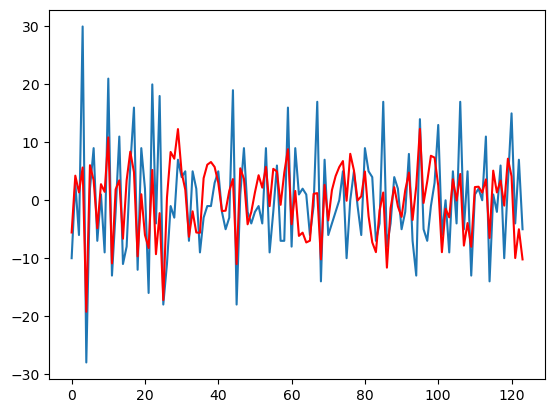

In [40]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

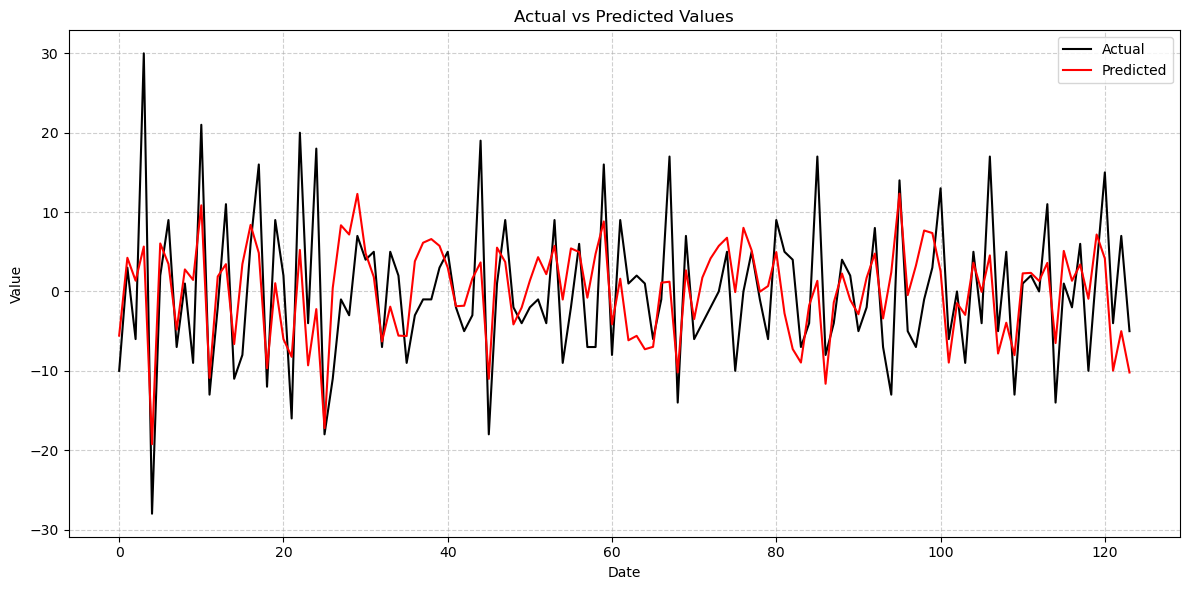

In [44]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))                                         

plt.plot(test, label='Actual', color='black')               
plt.plot(predictions, label='Predicted', color='red')        

plt.title('Actual vs Predicted Values')                                
plt.xlabel('Date')                                                 
plt.ylabel('Value')                                                    

plt.legend()                                                         
plt.grid(True, linestyle='--', alpha=0.6)                              
plt.tight_layout()                                                   
plt.show()                                                        

### Finalize and Save Time Series Forecast Model

In [47]:
X = difference(series.values)

# fit model
model = AutoReg(train, lags=6)    # Define model
model_fit = model.fit()           # Fit the model

# save model to file
model_fit.save('ar_model.pkl')

# save the differenced dataset
np.save('ar_data.npy', X)

# save the last ob
np.save('ar_obs.npy', [series.values[-1]])